# Main arguments

### Execute always this cell

In [1]:
# There are 2 main models: 1 output --> 0 vs 1234; and 3 outputs --> 0 vs 1 vs 234. Both models are EfficientNetB5 networks

# CHANGE THIS VARIABLE TO CHOOSE 0VS1234 MODEL OR 0VS1VS234 MODEL
classification_0vs1234 = True
# This variable indicates whether the main purpose is to be the 0vs1234 or 01vs234 classification
use_01_234 = False 
# It cannot be True if trained model does not support 3 classes
assert not use_01_234 or (use_01_234 and not classification_0vs1234)

# Specify how 'ground truth' values are given
ONE_HOT_FORMAT = False
# False ---> Ground truth arrays have only 2 columns: class (integer number, not one-hot array) - dr level

# Reference metric
metric_id = 'val_AUC'
# metric_id = 'val_Sp_at_95_sens'

base_path = 'saved_weights/efficientNetB5/SGD_bal_bs4/' if classification_0vs1234 else 'saved_weights/efficientNetB5/SGD_bal_0-1-234_bs4/'

DR_LEVELS_PER_CLASS = [[0], [1,2,3,4]] if classification_0vs1234 else [[0], [1], [2,3,4]]

# Get model preodiction on test dataset

Execute these cells the first time and saves the model's predictions.

In [11]:
# Import necessary modules
import lib.models as models
import lib.dataset as dt
import pandas as pd
import numpy as np
import os

In [ ]:
%%time

# Specify dataset file and its parameters
test_files = ['DATASET-TEST-10.csv', 'messidor_test-ALL.csv', 'messidor_2_test-ALL.csv', 'messidor2_abramoff_test-ALL.csv']

ONE_HOT_FORMAT = False

TEST_BATCH_SIZE = 1
TEST_DATA_AUG = False
TEST_BALANCED = False
TEST_PREFETCH = 1
TEST_TAKE_SIZE = None

# Define and load model
model = models.efficientNetB5.get_model(input_shape=(540,540,3), num_outputs=len(DR_LEVELS_PER_CLASS))

with open(base_path + 'model_config.json', 'w') as json_file:
    json_file.write(model.to_json())

model.summary()

# Load weights
if use_01_234:
    model.load_weights(base_path + 'best_' + metric_id.replace('val_', '') + '_DRlvls_01_234.h5')
else:
    model.load_weights(base_path + 'best_' + metric_id.replace('val_', '') + '_DRlvls_0_1234.h5')

    
for TEST_FILE in test_files:

    # Load test dataset (validation outputs have been saved when training)
    test_dataset, y_true_test = dt.create_dataset_new(TEST_FILE, 
                                                      DR_LEVELS_PER_CLASS, 
                                                      balanced=TEST_BALANCED,
                                                      apply_data_augmentation=TEST_DATA_AUG,
                                                      batch_size=TEST_BATCH_SIZE,
                                                      prefetch_buffer=TEST_PREFETCH, 
                                                      is_validation=True,
                                                      one_hot_format=ONE_HOT_FORMAT,
                                                      size=TEST_TAKE_SIZE,
                                                      check_exists_all_dr_lvls=False)

    # Messidor_2_abramoff contains only 2 labels: 0 and 1. There is no classification per DR grade
    # 0 - means: 0,1 DR levels
    # 1 - means: 2,3,4 DR levels
    # So, to measute 'correctly' our model with this dataset, we mark as DR level = 2 every non 0 image
    if TEST_FILE == 'messidor2_abramoff_test-ALL.csv':
        y_true_test = y_true_test * 2

    # Save ground truth for test dataset
    np.save(base_path + 'ground_truth_' + TEST_FILE.split('.')[0] + '.npy', y_true_test)

    # Get model prediction on test dataset
    print('Getting prediction on test dataset')
    y_pred_test = model.predict(test_dataset)

    # Save model prediction
    if use_01_234:
        np.save(base_path + 'model_prediction_0-1-234_on_' + TEST_FILE.split('.')[0] + '.npy', y_pred_test)
    else:
        np.save(base_path + 'model_prediction_on_' + TEST_FILE.split('.')[0] + '.npy', y_pred_test)
    
print('Output saved. Restart kernel to free GPU memory')

Once the test prediction is saved, you can restart the kernel to release the GPU memory. The following steps do not require Tensorflow or GPU

# Evaluate model on validation and test datasets

In [2]:
import lib.evaluation as ev
import lib.plotting as plot

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os

from importlib import reload
from IPython.display import display

In [3]:
# Get validation output with highest AUC value
metrics_evolution = pd.read_csv(base_path + 'training_evolution.csv')

if not use_01_234:
    max_value_index = np.argmax(metrics_evolution[metric_id+'_DRlvls_0_1234'].tolist())
else:
    max_value_index = np.argmax(metrics_evolution[metric_id+'_DRlvls_01_234'].tolist())
    
print('The highest ' + metric_id.replace('val_', '') + ' value was obtained on epoch:', max_value_index, '- So we have to read its output file')
# So, we have to get that file from 'validation_outputs' directory

The highest AUC value was obtained on epoch: 37 - So we have to read its output file


In [4]:
# Get validation and test ground truth and predictions
y_pred_val = np.load(base_path + 'validation_outputs/' + 'output_epoch_' + str(max_value_index).zfill(4) + '.npy') # Using the index 
y_true_val = np.load(base_path + 'ground_truth_val.npy').astype(np.uint8)

# Dictionary for test datasets - Key: filename - Value: dataset name
test_datasets = {
    'DATASET-TEST-10': 'EYEPACS',
#     'messidor_test-ALL': 'Messidor Original',
    'messidor_2_test-ALL': 'Messidor 2',
#     'messidor2_abramoff_test-ALL': 'Messidor 2 Abramoff'
}

# Load model's predictions and ground truth arrays
if not use_01_234:
    dict_y_pred_tests = {x: np.load(base_path + 'model_prediction_on_' + x + '.npy') for x in test_datasets}
else:
    dict_y_pred_tests = {x: np.load(base_path + 'model_prediction_0-1-234_on_' + x + '.npy') for x in test_datasets}
dict_y_true_tests = {x: np.load(base_path + 'ground_truth_' + x + '.npy').astype(np.uint8) for x in test_datasets}

Validation dataset
This dataset has 3598 images
	DR lvl 0 has 1799 images
	DR lvl 1 has 522 images
	DR lvl 2 has 997 images
	DR lvl 3 has 138 images
	DR lvl 4 has 142 images


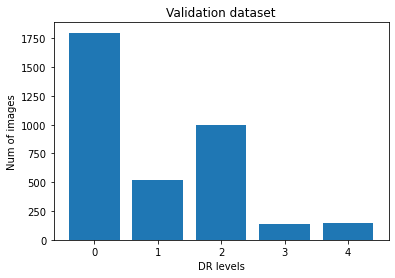

----
EYEPACS Test dataset
This dataset has 7102 images
	DR lvl 0 has 5223 images
	DR lvl 1 has 505 images
	DR lvl 2 has 1055 images
	DR lvl 3 has 176 images
	DR lvl 4 has 143 images


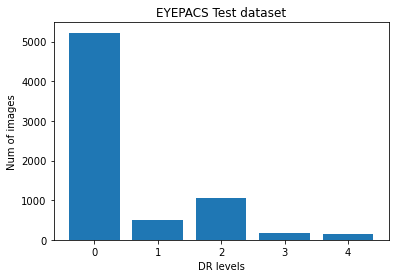

----
Messidor 2 Test dataset
This dataset has 1744 images
	DR lvl 0 has 1017 images
	DR lvl 1 has 270 images
	DR lvl 2 has 347 images
	DR lvl 3 has 75 images
	DR lvl 4 has 35 images


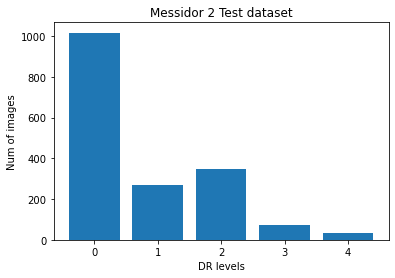

In [5]:
def count_images_per_dr_lvl(array, dataset_name=None):
    count_dict = {i:0 for i in np.sort(np.unique(array))}
    for i in array:
        count_dict[i] += 1
    print('This dataset has', array.shape[0], 'images')
    for i in count_dict:
        print('\tDR lvl', i, 'has', count_dict[i], 'images')
    
    if dataset_name != None:
        
        plt.figure()
        plt.bar(list(count_dict.keys()), [count_dict[x] for x in count_dict])
        plt.xlabel('DR levels')
        plt.ylabel('Num of images')
        plt.title(dataset_name)
        plt.show()

print('Validation dataset')
count_images_per_dr_lvl(y_true_val[:,-1], 'Validation dataset')

for dt in test_datasets:
    print('----')
    print(test_datasets[dt], 'Test dataset')
    count_images_per_dr_lvl(dict_y_true_tests[dt][:,-1], test_datasets[dt] + ' Test dataset')

### Convert true labels into one-hot format

In [6]:
def to_one_hot(array, n_labels):
    assert array.ndim == 1
    one_hot = np.zeros((array.shape[0], n_labels), dtype=array.dtype)
    
    # Ensure no label is bigger than 'n_labels'
    array = np.clip(array, 0, n_labels-1)
    one_hot[np.arange(array.shape[0]), array] = 1
    return one_hot

if not ONE_HOT_FORMAT:
    # Ground truth arrays have only 2 columns: class - dr level
    # Class column must be splitted as specified in 'DR_LEVELS_PER_CLASS'
    
    y_true_val = np.column_stack((to_one_hot(y_true_val[:,0], len(DR_LEVELS_PER_CLASS)),
                                  y_true_val[:,1]))
    
    for dt in test_datasets:      
        dict_y_true_tests[dt] = np.column_stack((to_one_hot(dict_y_true_tests[dt][:,0], len(DR_LEVELS_PER_CLASS)),
                                                 dict_y_true_tests[dt][:,1]))

### Compute ROCs for validation and test datasets

In [7]:
%%time
reload(ev)
# Get ROC curves for validation and test sets

# Classification 0 vs 1234 -- 2 classes ---> 1 == DR presence (midl, moderate, severe and proliferative)
# Classification 0 vs 1 vs 234 -- 3 classes ---> 1 == mild DR, 2 == moderate or worse DR
classes = [1] if classification_0vs1234 else [1, 2, (1,2)]

ROC_names = ['DR levels 1,2,3,4'] if classification_0vs1234 else ['DR level 1', 'DR levels 2,3,4', 'DR levels 1,2,3,4']

fpr_val, tpr_val, thr_val = ev.get_roc_curve(y_true_val[:,:-1], y_pred_val, classes=classes, num_thresholds=500, remove_under_ROC_points=True)

# One dictionary per test dataset
test_ROCs = {dt: {} for dt in test_datasets}

for dt in test_datasets:
    
    fpr_test, tpr_test, thr_test = ev.get_roc_curve(dict_y_true_tests[dt][:,:-1], dict_y_pred_tests[dt], classes=classes, num_thresholds=500, remove_under_ROC_points=True)
    
    test_ROCs[dt]['fpr'] = fpr_test
    test_ROCs[dt]['tpr'] = tpr_test
    test_ROCs[dt]['thr'] = thr_test

CPU times: user 11.5 s, sys: 0 ns, total: 11.5 s
Wall time: 11.5 s


In [8]:
%%time
reload(ev)
# Get closest points to 0,1 in validation ROCs
val_thr_closests = []
for i in range(len(fpr_val)):
    _, _, th = ev.find_closest_point_to_01(fpr_val[i], tpr_val[i], thr_val[i])
    val_thr_closests.append(th)
val_thr_closests = [tuple(val_thr_closests)]

# Thresholds must be saved in this form
# There will be a threshold for each ROC/Classification (for instance: 0vs1234, 01vs234 and 1 vs 0234). These thresholds are packed into a tuple (thr_roc1, thr_roc2, thr_roc3,...) and they will have the same meaning (closest point to (0,1) on each ROC)
# This tuple will be added into a list, so we can get other thresholds (98, 95, 93, 90 sensibility)

val_thr_closests

CPU times: user 4.23 ms, sys: 0 ns, total: 4.23 ms
Wall time: 9.9 ms


[(0.4108216432865731,)]

## Show performance on validation dataset

In [9]:
# Operative points
reload(ev)

dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(y_true_val, classes=classes)

# Sensibility operative points 
operative_sens_points = [98, 95, 93, 90, 85]

results_val, fns_v = ev.get_results_at_operative_points(fpr_val,
                                                        tpr_val,
                                                        thr_val,
                                                        y_pred_val,
                                                        classes,
                                                        dr_levels,
                                                        dr_classifications,
                                                        operative_sens_points,
                                                        interpolate_sens_points=False,
                                                        operative_thresholds=val_thr_closests)

for class_ in range(len(classes)):
    display(results_val[class_].style.set_caption('Validation dataset - Class ' + str(classes[class_]) + \
                                                  ' = DR Lvls: ' + ','.join(list(map(str, list(dr_levels[class_])))) + \
                                                  ' - AUC: ' + str(round(ev.get_auc(fpr_val[class_], tpr_val[class_]), 4))))

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_1 (sample),FNR_2 (sample),FNR_3 (sample),FNR_4 (sample),Thresholds
0,98,98.500000,21.400000,1.500000,3.070000,1.100000,0.000000,0.000000,0.060120
1,95,95.720000,44.580000,4.280000,9.000000,2.910000,0.000000,0.700000,0.108216
2,93,95.720000,44.580000,4.280000,9.000000,2.910000,0.000000,0.700000,0.108216
3,90,91.050000,66.810000,8.950000,18.970000,5.820000,0.720000,2.110000,0.190381
4,85,85.440000,86.270000,14.560000,32.380000,8.430000,1.450000,4.930000,0.368737
5,Closest point,84.160000,88.100000,15.840000,35.060000,9.330000,1.450000,4.930000,0.410822


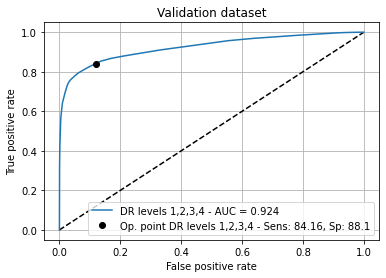

In [10]:
reload(plot)

%matplotlib inline
# 'auto' en lugar de 'inline' para que se abra en una nueva ventana

plot.plot_roc_curve(fpr_val, 
                    tpr_val, 
                    thr_val, 
                    'Validation dataset', 
                    ROC_names, 
                    operative_threshold=None, 
                    grid=True, 
                    show_points=False,
                    show_zoomed=False)

## Show performance on test datasets

In [11]:
reload(ev)

# Get thresholds from Validation ROCs
operative_thresholds = [res['Thresholds'] for res in results_val]
operative_thresholds = [e for e in zip(*operative_thresholds)]

fns_t_all = []

for dt in test_datasets:
    
    # Operative points
    dr_levels, dr_classifications = ev.get_dr_levels_and_classifications_per_classes(dict_y_true_tests[dt], classes=classes)


    results_test, fns_t = ev.get_results_at_operative_points(test_ROCs[dt]['fpr'],
                                                             test_ROCs[dt]['tpr'],
                                                             test_ROCs[dt]['thr'],
                                                             dict_y_pred_tests[dt],
                                                             classes,
                                                             dr_levels,
                                                             dr_classifications,
                                                             operative_thresholds=operative_thresholds)

    fns_t_all.append(fns_t)
    
    for i in range(len(results_test)):
        results_test[i].insert(0, 'Sens. Operative point', results_val[i]['Sens. Operative point'].tolist())

    for class_ in range(len(classes)):
        display(results_test[class_].style.set_caption(test_datasets[dt] + ' Test dataset - Class ' + str(classes[class_]) + \
                                                       ' = DR Lvls: ' + ','.join(list(map(str, list(dr_levels[class_])))) + \
                                                       ' - AUC: ' + str(round(ev.get_auc(test_ROCs[dt]['fpr'][class_], test_ROCs[dt]['tpr'][class_]), 4))))
    print('------------------------------------------------------------------------------------------------------')

,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_1 (sample),FNR_2 (sample),FNR_3 (sample),FNR_4 (sample),Thresholds
0,98,98.390000,20.660000,1.610000,4.160000,0.950000,0.000000,0.000000,0.060120
1,95,95.360000,41.480000,4.640000,11.290000,3.410000,0.570000,0.000000,0.108216
2,93,95.360000,41.480000,4.640000,11.290000,3.410000,0.570000,0.000000,0.108216
3,90,91.250000,64.660000,8.750000,20.200000,6.540000,0.570000,0.700000,0.190381
4,85,86.190000,84.750000,13.810000,30.300000,9.760000,1.700000,2.100000,0.368737
5,Closest point,85.090000,87.080000,14.910000,32.280000,10.710000,1.700000,2.800000,0.410822


------------------------------------------------------------------------------------------------------


,Sens. Operative point,Sensibility,Specificity,False negative rate,FNR_1 (sample),FNR_2 (sample),FNR_3 (sample),FNR_4 (sample),Thresholds
0,98,99.130000,19.820000,0.870000,2.590000,0.000000,0.000000,0.000000,0.060120
1,95,97.840000,36.510000,2.160000,6.670000,0.000000,0.000000,0.000000,0.108216
2,93,97.840000,36.510000,2.160000,6.670000,0.000000,0.000000,0.000000,0.108216
3,90,95.450000,54.580000,4.550000,12.590000,0.000000,0.000000,0.000000,0.190381
4,85,91.860000,70.130000,8.140000,21.480000,0.580000,0.000000,0.000000,0.368737
5,Closest point,91.000000,72.300000,9.000000,24.440000,1.150000,0.000000,0.000000,0.410822


------------------------------------------------------------------------------------------------------


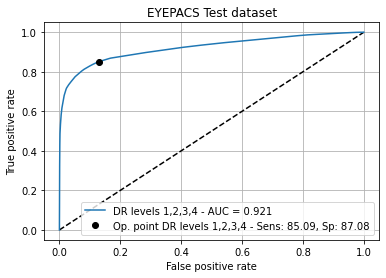

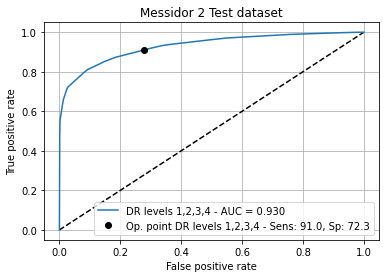

In [12]:
reload(plot)

for dt in test_datasets:
    
    plot.plot_roc_curve(test_ROCs[dt]['fpr'], 
                        test_ROCs[dt]['tpr'], 
                        test_ROCs[dt]['thr'], 
                        test_datasets[dt] + ' Test dataset', 
                        ROC_names, 
                        operative_threshold=operative_thresholds[-1], 
                        grid=True, 
                        show_points=False,
                        show_zoomed=False)

### See accuracy and false negatives

In [13]:
reload(ev)

acc_thresholds = val_thr_closests if classification_0vs1234 else val_thr_closests[-1]

print('Using closest threshold to (0,1):', acc_thresholds)

val_acc, val_pred_lb = ev.get_accuracy(y_true_val, y_pred_val, acc_thresholds, return_pred=True)
print('Validation accuracy:', round(val_acc, 4))

print('False negatives on validation')
false_negatives_per_dr_lvl_val = ev.get_false_negatives_per_dr_level(y_true_val, val_pred_lb)

for dr in false_negatives_per_dr_lvl_val:
    print('\tDR level', dr, '-', len(false_negatives_per_dr_lvl_val[dr]))

print()    

false_negatives_per_dr_lvl_test = []

for dt in test_datasets:
    t_acc, t_pred_lb = ev.get_accuracy(dict_y_true_tests[dt], dict_y_pred_tests[dt], acc_thresholds, return_pred=True)
    
    print(dt,'Test dataset accuracy:', round(t_acc, 4))

    false_negatives_per_dr_lvl_test.append(ev.get_false_negatives_per_dr_level(dict_y_true_tests[dt], t_pred_lb))
    
print('False negatives on test datasets')

for dt, fns_t in zip(list(test_datasets), false_negatives_per_dr_lvl_test):
    
    print('\tDataset', dt)
    
    for dr_lvl in fns_t:
        print('\t\tDR level', dr_lvl, '-', len(fns_t[dr_lvl]))

        
# 90 sens -- 3
other_threshold = 3

acc_thresholds = [(results_val[-1]['Thresholds'].tolist()[other_threshold],)] if classification_0vs1234 else \
                    [(results_val[ii]['Thresholds'].tolist()[other_threshold],) for ii in range(len(results_val))]

print('\nUsing another threshold (90% sens at validation):', acc_thresholds, ' -----\n')

val_acc, val_pred_lb = ev.get_accuracy(y_true_val, y_pred_val, acc_thresholds, return_pred=True)
print('Validation accuracy:', round(val_acc, 4))

print('False negatives on validation')
false_negatives_per_dr_lvl_val = ev.get_false_negatives_per_dr_level(y_true_val, val_pred_lb)

for dr in false_negatives_per_dr_lvl_val:
    print('\tDR level', dr, '-', len(false_negatives_per_dr_lvl_val[dr]))

print()    

false_negatives_per_dr_lvl_test = []
predicted_test_labels = []

for dt in test_datasets:
    t_acc, t_pred_lb = ev.get_accuracy(dict_y_true_tests[dt], dict_y_pred_tests[dt], acc_thresholds, return_pred=True)
    
    print(dt,'Test dataset accuracy:', round(t_acc, 4))

    predicted_test_labels.append(t_pred_lb)
    false_negatives_per_dr_lvl_test.append(ev.get_false_negatives_per_dr_level(dict_y_true_tests[dt], t_pred_lb))
    
print('False negatives on test datasets')

for dt, fns_t in zip(list(test_datasets), false_negatives_per_dr_lvl_test):
    
    print('\tDataset', dt)
    
    for dr_lvl in fns_t:
        print('\t\tDR level', dr_lvl, '-', len(fns_t[dr_lvl]))

Using closest threshold to (0,1): [(0.4108216432865731,)]
Validation accuracy: 0.8613
False negatives on validation
	DR level 1 - 183
	DR level 2 - 93
	DR level 3 - 2
	DR level 4 - 7

DATASET-TEST-10 Test dataset accuracy: 0.8652
messidor_2_test-ALL Test dataset accuracy: 0.801
False negatives on test datasets
	Dataset DATASET-TEST-10
		DR level 1 - 163
		DR level 2 - 113
		DR level 3 - 3
		DR level 4 - 4
	Dataset messidor_2_test-ALL
		DR level 1 - 66
		DR level 2 - 4
		DR level 3 - 0
		DR level 4 - 0

Using another threshold (90% sens at validation): [(0.1903807615230461,)]  -----

Validation accuracy: 0.7893
False negatives on validation
	DR level 1 - 99
	DR level 2 - 58
	DR level 3 - 1
	DR level 4 - 3

DATASET-TEST-10 Test dataset accuracy: 0.7218
messidor_2_test-ALL Test dataset accuracy: 0.7116
False negatives on test datasets
	Dataset DATASET-TEST-10
		DR level 1 - 102
		DR level 2 - 69
		DR level 3 - 1
		DR level 4 - 1
	Dataset messidor_2_test-ALL
		DR level 1 - 34
		DR level 2 

In [14]:
'acc_thresholds = ' + str(acc_thresholds)

'acc_thresholds = [(0.1903807615230461,)]'

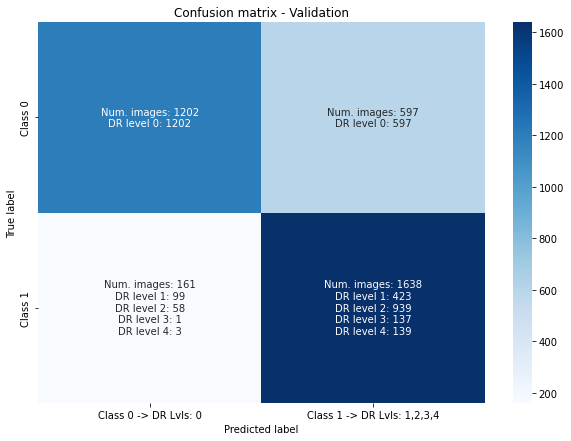

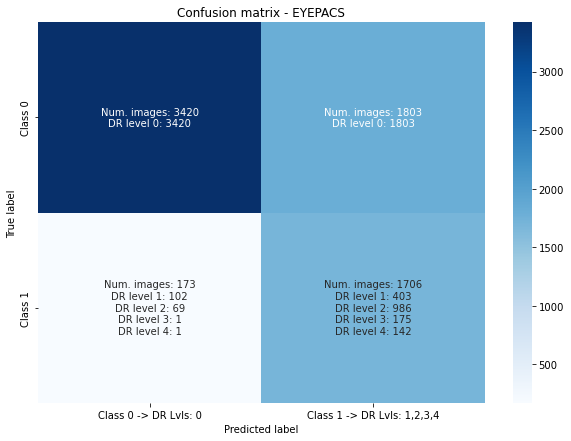

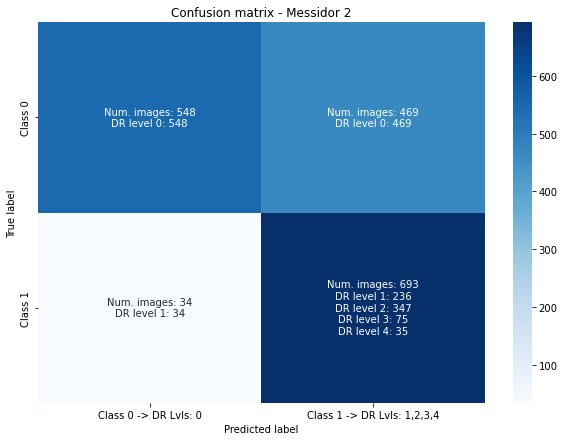

In [15]:
%matplotlib inline
# Show matrix confusion for all datasets (validation and test datasets)

for true_array, pred_array, dataset_name in zip([y_true_val, *[dict_y_true_tests[dt] for dt in test_datasets]], \
                                                [val_pred_lb, *predicted_test_labels], \
                                                ['Validation', *test_datasets.values()]):
    
    # Create the confusion matrix using the predicted label array        
    matrix, dr_lvls_per_box = ev.create_confusion_matrix(true_array, pred_array, len(DR_LEVELS_PER_CLASS), DR_LEVELS_PER_CLASS)

    # Show the confusion matrix
    plot.plot_confusion_metric(matrix, dr_lvls_per_box, DR_LEVELS_PER_CLASS, dataset_name)

### Get and save paths to False Negative results

Validation and test datasets were not shuffled

In [16]:
fn_path = base_path + 'false_negatives/'
if not os.path.exists(fn_path):
    os.mkdir(fn_path)

In [17]:
fn_path = base_path + 'false_negatives/'
if not os.path.exists(fn_path):
    os.mkdir(fn_path)

# Validation
validation_csv = 'DATASET-VALIDATION-10_BALANCED.csv' if classification_0vs1234 else 'DATASET-VALIDATION-10-BALANCED-0-1-234.csv'

validation_data = pd.read_csv(validation_csv)

all_fns_val = []

all_fns_val = list(set().union(*false_negatives_per_dr_lvl_val.values()))
all_fns_val.sort()

validation_missclassified_data = pd.DataFrame({
    'path': validation_data.loc[all_fns_val]['path'].tolist(),
    'DR_level': validation_data.loc[all_fns_val]['DR_level'].tolist(),
    'true_label': np.argmax(y_true_val[:,:-1], axis=1)[all_fns_val].tolist(),
    'predicted_label': val_pred_lb[all_fns_val].tolist()
})

validation_missclassified_csv = 'VALIDATION-BAL_0_1234_FNS.csv' if classification_0vs1234 else 'VALIDATION-BAL_0_1_234_FNS.csv'

validation_missclassified_csv = fn_path + validation_missclassified_csv

validation_missclassified_data.to_csv(validation_missclassified_csv, index=False)

# Test datasets

for i, dt in enumerate(test_datasets):
    
    test_data = pd.read_csv(dt + '.csv')

    all_fns_test = list(set().union(*false_negatives_per_dr_lvl_test[i].values()))
    all_fns_test.sort()

    test_missclassified_data = pd.DataFrame({
        'path': test_data.loc[all_fns_test]['path'].tolist(),
        'DR_level': test_data.loc[all_fns_test]['DR_level'].tolist(),
        'true_label': np.argmax(dict_y_true_tests[dt][:,:-1], axis=1)[all_fns_test].tolist(),
        'predicted_label': predicted_test_labels[i][all_fns_test].tolist()
    })
    
    test_missclassified_csv = fn_path + dt + '_FNS.csv'
    
    test_missclassified_data.to_csv(test_missclassified_csv, index=False)

In [18]:
print(os.listdir(fn_path))

['VALIDATION-BAL_0_1234_FNS.csv', 'messidor_2_test-ALL_FNS.csv', 'DATASET-TEST-10_FNS.csv']


In [20]:
# Crear una copia de las imágenes con RD errónemente clasificadas como sanas en el directorio 'auxx'
# De esta forma, será más fácil revisar dichas imágenes

from shutil import rmtree, copy2

aux_path = 'auxx'
if os.path.exists(aux_path):
    rmtree(aux_path)
    
os.mkdir(aux_path)

df = pd.read_csv(fn_path + 'DATASET-TEST-10_FNS.csv')

for i, row in enumerate(df[(df['DR_level'] == 2) & (df['predicted_label'] == 0)].itertuples()):
    copy2(row.path, aux_path)
#     plt.imshow(cv2.cvtColor(cv2.imread(row.path), cv2.COLOR_BGR2RGB))
#     plt.show()

## De aquí para abajo las celdas fueron empleadas para la generación de los gráficos de cómo se distribuyen los datasets

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [20]:
df = pd.read_csv('data/processed_datasets/0_csvs/eyepacs.csv')

print('There are:', df.shape[0], 'images on this dataset')

FileNotFoundError: [Errno 2] No such file or directory: 'data/processed_datasets/0_csvs/eyepacs.csv'

In [390]:
df.columns

Index(['image', 'path', 'DR_level', 'DME_level', 'gradability', 'old_size_x',
       'old_size_y'],
      dtype='object')

In [393]:
%matplotlib auto
display(df.groupby('DR_level')['image'].count())
df.groupby('DR_level')['image'].count().plot(kind='bar')
plt.xlabel('Niveles de Retinopatía Diabética')
plt.ylabel('Número de pacientes')

Using matplotlib backend: TkAgg


DR_level
0    65337
1     6203
2    13151
3     2087
4     1914
Name: image, dtype: int64

Text(0, 0.5, 'Número de pacientes')

In [394]:
%matplotlib auto

display(df.groupby('gradability').count())

df.loc[df['gradability'] == 1].groupby('DR_level')['image'].count().plot(kind='bar')
plt.xlabel('Niveles de Retinopatía Diabética')
plt.ylabel('Número de pacientes')

Using matplotlib backend: TkAgg


,image,path,DR_level,DME_level,old_size_x,old_size_y
gradability,,,,,,
0,17641,17641,17641,17641,17641,17641
1,71051,71051,71051,71051,71051,71051


Text(0, 0.5, 'Número de pacientes')

Extraer una muestra de imágenes de EYEPACS de todos los niveles de RD

In [395]:
import matplotlib.gridspec as gridspec

n_rows = n_cols = 3

sample_allDR_lvls = df.loc[df['gradability'] == 1].groupby('DR_level').apply(lambda x: x.sample(3)).sample(n_rows*n_cols)['path'].tolist()

plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(n_rows, n_cols)
gs.update(wspace=0.05, hspace=0.2)

for i, img in enumerate(sample_allDR_lvls):
    
    dr_lvl = img.split('eyepacs/')[-1][0]
    
    ax = plt.subplot(gs[i])
    
    plt.imshow(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB))
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    tit = 'Sano' if int(dr_lvl) == 0 else 'Nivel de RD: ' + dr_lvl
    plt.title(tit)
    plt.axis('off')

Crear columna etiqueta para establecer a qué clase (de las definidas) se corresponde cada una de las imágenes

In [397]:
dff = df.loc[df['gradability'] == 1]

dr_levels = dff['DR_level'].tolist()

asignations = [-1 for i in DR_LEVELS_PER_CLASS for j in i] # [[0], [1], [2,3,4]] --> [-1, -1, -1, -1, -1]

for i, class_ in enumerate(DR_LEVELS_PER_CLASS):
    for dr_lvl in class_:
        asignations[dr_lvl] = i

labels = [asignations[dr_lvl] for dr_lvl in dr_levels]

dff.insert(3, 'label', labels, True)

display(dff)

,image,path,DR_level,label,DME_level,gradability,old_size_x,old_size_y
17641,4905_right,data/processed_datasets/eyepacs/0/4905_right.png,0,0,-1,1,2358,1611
17642,39753_right,data/processed_datasets/eyepacs/0/39753_right.png,0,0,-1,1,2354,1620
17643,21866_right,data/processed_datasets/eyepacs/2/21866_right.png,2,1,-1,1,2359,1611
17644,39563_right,data/processed_datasets/eyepacs/0/39563_right.png,0,0,-1,1,1738,1168
17645,5391_right,data/processed_datasets/eyepacs/0/5391_right.png,0,0,-1,1,2354,1621
...,...,...,...,...,...,...,...,...
88687,21875_right,data/processed_datasets/eyepacs/0/21875_right.png,0,0,-1,1,1940,1331
88688,21662_right,data/processed_datasets/eyepacs/2/21662_right.png,2,1,-1,1,1934,1297
88689,9372_left,data/processed_datasets/eyepacs/0/9372_left.png,0,0,-1,1,1941,1331
88690,26376_right,data/processed_datasets/eyepacs/0/26376_right.png,0,0,-1,1,1939,1331


In [203]:
pd.read_csv('data/processed_datasets/0_csvs/messidor_2.csv').groupby('gradability').count()

,image,path,DR_level,DME_level,old_size_x,old_size_y
gradability,,,,,,
0,4,4,4,4,4,4
1,1744,1744,1744,1744,1744,1744


In [22]:
DR_LEVELS_PER_CLASS

[[0], [1], [2, 3, 4]]

In [40]:
train_file = 'DATASET-TRAIN-80.csv'
train_bal_file = 'TRAIN-0-1-234-BAL.csv'
val_file_noBal = 'DATASET-VALIDATION-10.csv'

val_file = 'DATASET-VALIDATION-10_BALANCED.csv' if classification_0vs1234 else 'DATASET-VALIDATION-10-BALANCED-0-1-234.csv'

titles = ['Entrenamiento', 'Entrenamiento balanceado', 'Validacion', 'Validacion balanceado', 'test EYEPACS', 'test Messidor 2']

for filename, tit in zip([train_file, train_bal_file, val_file_noBal, val_file] + [x + '.csv' for x in test_datasets.keys()], titles):

    df = pd.read_csv(filename)

    asignations = [-1 for i in DR_LEVELS_PER_CLASS for j in i] # example: [[0], [1], [2,3,4]] --> [-1, -1, -1, -1, -1]

    for i, class_ in enumerate(DR_LEVELS_PER_CLASS):
        for dr_lvl in class_:
            asignations[dr_lvl] = i

    labels = [asignations[dr_lvl] for dr_lvl in df['DR_level'].tolist()]

    df.drop('label', axis=1, inplace=True)
    df.insert(1, 'label', labels)

    num_imgs_smaller_class = df.groupby('label')['path'].count().min()

#     print(num_imgs_smaller_class)

    # https://stackoverflow.com/questions/46375147/create-new-columns-from-unique-row-values-in-a-pandas-dataframe 
    df = df.groupby(['label','DR_level'])['path'].count().reset_index()

    df = df.pivot_table(index=['label'], 
                        columns=['DR_level'],
                        values='path')

    print(tit)
    display(df)

    df.plot(kind='bar', stacked=True)

    plt.title('Reparto de las imágenes entre las clases en el conjunto de ' + tit)
    plt.xlabel('Clases definidas')
    plt.ylabel('Número de imágenes')

    # plt.ylim([0, num_imgs_smaller_class])

    plt.plot([-1, max(labels)+1], [num_imgs_smaller_class, num_imgs_smaller_class], 'k--')

Entrenamiento


DR_level,0,1,2,3,4
label,,,,,
0,42149.0,NaN,NaN,NaN,NaN
1,NaN,4049.0,NaN,NaN,NaN
2,NaN,NaN,8241.0,1283.0,1100.0


Entrenamiento balanceado


DR_level,0,1,2,3,4
label,,,,,
0,4049.0,NaN,NaN,NaN,NaN
1,NaN,4049.0,NaN,NaN,NaN
2,NaN,NaN,3127.0,498.0,424.0


Validacion


DR_level,0,1,2,3,4
label,,,,,
0,5304.0,NaN,NaN,NaN,NaN
1,NaN,522.0,NaN,NaN,NaN
2,NaN,NaN,997.0,138.0,142.0


Validacion balanceado


DR_level,0,1,2,3,4
label,,,,,
0,522.0,NaN,NaN,NaN,NaN
1,NaN,522.0,NaN,NaN,NaN
2,NaN,NaN,402.0,66.0,54.0


test EYEPACS


DR_level,0,1,2,3,4
label,,,,,
0,5223.0,NaN,NaN,NaN,NaN
1,NaN,505.0,NaN,NaN,NaN
2,NaN,NaN,1055.0,176.0,143.0


test Messidor 2


DR_level,0,1,2,3,4
label,,,,,
0,1017.0,NaN,NaN,NaN,NaN
1,NaN,270.0,NaN,NaN,NaN
2,NaN,NaN,347.0,75.0,35.0
